In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pylab as pl
import sympy as sy
%matplotlib inline

\begin{eqnarray}
\partial_t v &=& J_F - J_{U}(v,w) - J_D(v,w) - J_{UD}(v)\\
\partial_t w &=& w^\kappa \left[\alpha_w(v) - \left( \alpha_w(v) + \beta_w(v) \right)w\right] \\
&=& u^\kappa \left[ \alpha_w(v)u -  \beta_w(v) (1-u) \right] 
= u^\kappa \left[ \left( \alpha_w(v) + \beta_w(v)\right)u - \beta_w(v) \right] \\
\alpha_i (v; v_i, b_i, z_i) &=& \exp \left[b_i z_i (v-v_i)  \right], 
\\
\beta_i (v; v_i, b_i, z_i) &=& \exp \left[(b_i-1) z_i (v-v_i)  \right]
\\
J_U(v,w) &=& A_U m_{\infty}(v) u \left[ \alpha_U(v) - \beta_U(v) \right] \\
J_D(v,w) &=& A_D (1-u) \left[ \alpha_D(v) - \beta_D(v) \right] \\
\end{eqnarray}



In [ ]:
def delDictItem(d,key):
  r = dict(d)
  del(r[key])
  return r

def biasedExp(x,a,b=1):
  return sy.exp(b * (x-a))

def sigmoid(x,a,n=1):
  xn = x**n
  return xn /(xn + a**n)

# ----------------------
# Numerics
# ----------------------
def RK2_autonomousStep(f, U, p):
    k = p['stepSize'] * f( U,p) / 2
    return U + p['stepSize'] * f( U + k,p)

def RK2_Autonomous(f, p, parNames=[],parValues=[]):
    """Second-order Runge-Kutta method to solve x' = f(x) with U(t[0]) = U0.
    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """
    nPar=len(parNames)
    U=np.zeros((p['nSteps'], np.prod(np.shape(p['ic']))),"float64")
    U[0]=p['ic']
    if nPar>0:
        for i in range(p['nSteps']-1):
            for nn in np.arange(nForc):
                p[parNames[nn]]=parValues[nn][i]
            U[i+1] = RK2_autonom|ousStep(f,U[i], p)
    else:
        for i in range(p['nSteps']-1):
            U[i+1] = RK2_autonomousStep(f,U[i], p)
    return U.transpose()

# ------------------------
# Vector fields
# ------------------------
def field2D(f,p):
    rango_x = np.linspace(p['xMin'],p['xMax'],p['xStepSize'])
    rango_y = np.linspace(p['yMin'],p['yMax'],p['yStepSize'])
    xVec,yVec = np.meshgrid(rango_x,rango_y)
    dx,dy = f(np.array([xVec,yVec]),p)
    return xVec,yVec,dx,dy

# ------------------------
# Bifurcations
# ------------------------
def fpList2eigenValues(xs,ys,Jacs):
    ee = list()
    for n in range(len(x)):
      J=Jacs[n]
      ee.append(np.linalg.eigvals(J(x[n],y[n])))
    return ee

def fixedPoint2D_typeMarker(eigenValues,ms=5,color_nodo='orange',color_foco='blue'):
    pf=dict()
    l1,l2 = eigenValues
    r1,r2 = np.real(eigenValues)
    i1,i2 = np.imag(eigenValues)
    pf['eigVal_1'] = l1; pf['eigVal_2']=l2; pf['r1']=r1; pf['r2']=r2; pf['i1']=i1; pf['i2']=i2;
    pf['transp'] = 1; pf['mfc']= 'white'; pf['ms']= ms
    if (i1*i2<0): 
        pf['tipo']='foco';pf['mec']=color_foco;
        if r1>0: 
            pf['localDyn']='repulsor'; pf['marker']='wo'; pf['mfc'] ='white'; 
        elif r1<0:
            pf['localDyn']='attractor'; pf['marker']='ko'; pf['mfc'] =color_foco
        else:
            pf['localDyn']='centre'; pf['marker']='o'; pf['mfc']= 'gray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    else: 
        pf['type']='nodo'; pf['mec']=color_nodo;
        if (r1*r2) < 0:
            pf['localDyn'] ='saddle'; pf['marker']='x'; pf['mfc']=color_nodo
        elif (r1*r2>0):
            if r1>0: pf['localDyn']='repulsor'; pf['marker']='o'; pf['mfc'] ='white' 
            if r1<0: pf['localDyn']='attractor'; pf['marker']='o'; pf['mfc'] =color_nodo 
        elif (r1*r2 == 0) | (r1*r2<1e-15): 
            pf['localDyn']='degen'; pf['marker']='o'; pf['mfc']= 'lightgray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    return pf

def fixedPoint2D_types(xs,ys,Jac):
    nfp = len(xs)
    lpf =list()
    for n in range(nfp):
        print
        evals= np.linalg.eigvals(Jac(xs[n],ys[n]))    
        lpf.append(fixedPoint2D_typeMarker(evals))
        lpf[n]['x_*']=xs[n]
        lpf[n]['y_*']=ys[n]
        lpf[n]['evals'] = evals
    return lpf

Up-Dn class

In [ ]:
class UD:
  w, v = sy.symbols('w v')
  def __init__(self, pars):
    self.parameters = pars
    self.dict2symbols(pars)
    self.defineFunctions()
    return 

  def dict2symbols(self,di):
    for k in di.keys():
      exec("self.%s = sy.Symbol('%s')"%(k,k))
    return 

  def defineFunctions(self):
    self.e_m = biasedExp( x=self.v, a=self.v_m, b=self.g_m)
    self.e_w = biasedExp( x=self.v, a=self.v_w, b=self.g_w)
    self.e_U = biasedExp( x=self.v, a=self.v_U, b=1)
    self.e_D = biasedExp( x=self.v, a=self.v_D, b=1)
    self.e_UD = biasedExp( x=self.v, a=self.v_UD, b=1)
    self.m_inf = self.e_m/ ( 1 + self.e_m)
    self.w_inf =  self.e_w / (1 + self.e_w)
    self.alpha_w = self.r_w * (self.e_w ** self.b_w)
    self.beta_w = self.r_w * (self.e_w ** (self.b_w-1))
    self.phi_U = (self.e_U**self.b_U)*(1 - sy.exp( self.v_U - self.v ))
    self.phi_D = (self.e_D**self.b_D)*(1 - sy.exp( self.v_D - self.v ))
    self.phi_UD = (self.e_UD**self.b_UD)*(1 - sy.exp( self.v_UD - self.v ))
    self.J_U = self.a_U * self.m_inf * (1-self.w) * self.phi_U
    self.J_D = self.a_D * self.w * self.phi_D
    self.J_UD = self.a_UD * self.phi_UD
    self.dv = self.a_F - self.J_U - self.J_D - self.J_UD
    self.J_inf = self.dv.subs({'w': self.w_inf})
    self.dw = self.w**self.kappa_w * (self.alpha_w - (self.alpha_w + self.beta_w)*self.w )
    self.dwv = sy.Matrix([self.dw,self.dv])
    return
  
  def nuFu_w_inf(self):
    return sy.lambdify(self.v,self.w_inf.subs(self.parameters),'numpy')

  def Jacobian_subsPars(self):
    return self.dwv.subs(self.parameters).jacobian([self.w, self.v]) 

  def nuFu_Jacobian(self):
    return sy.lambdify([self.w,self.v], self.Jacobian_subsPars(), 'numpy')

  def subsParameters(self, expr, di):
     str0 = "self._%s = self.%s.subs(di)"%(expr,expr,)
     exec(str0)
     return

  def nuFu_parameterFromFP(self,parName='a_F'):
    pp = dict(self.parameters); pp.pop(parName)
    #print(self.J_inf.subs(pp))
    self.parFP = sy.solve(self.J_inf.subs(pp), parName)[0]
    #print(self.parFP)
    return sy.lambdify(['v'], self.parFP,'numpy')

  def eigvaluesFromFP(self,fp, parName = 'a_F'):
    wStar,vStar = fp
    self.fpfn = self.nuFu_parameterFromFP(parName)
    parVal = self.fpfn(vStar)
    upDn.parameters[parName] = parVal
    Jac = self.nuFu_Jacobian()
    return parVal, la.eigvals(Jac(wStar,vStar))
    

In [96]:
v_T = 26.6; C_m = 20.0; vTCm= v_T * C_m
voltages = {'v_w':0/v_T, 'v_m': -20.0/v_T,'v_U':60.0/v_T, 'v_D':-90.0/v_T, 'v_UD':-60.0/v_T}
biases = {'b_w':0.6, 'b_U':0.5, 'b_D':0.5, 'b_UD':0.5, 'g_m':5, 'g_w':3.5}
rates = {'r_w':1.0,'a_F':0.0,'a_U': 100.0, 'a_D': 400.0, 'a_UD':1}
p = {'v_T': v_T,'vTCm':v_T * C_m, 'kappa_w':0.3}
p= {**p, **voltages, **biases, **rates}
upDn = UD(p)

In [97]:
pp = dict(p); 
parName = 'a_F'
pp.pop(parName)
wInf = upDn.nuFu_w_inf()
vStars= np.arange(-3,0,0.1)
fps = list(); parVals = list(); eigenVals = list(); fpTM=list()
for vv in vStars:  
  pv, ev = upDn.eigvaluesFromFP([wInf(vv),vv],parName=parName)
  fps.append([wInf(vv),vv]); parVals.append(pv); #eigenVals.append(ev)
  fpTM.append(fixedPoint2D_type(ev,ms=5,color_nodo='blue',color_foco='gray'))

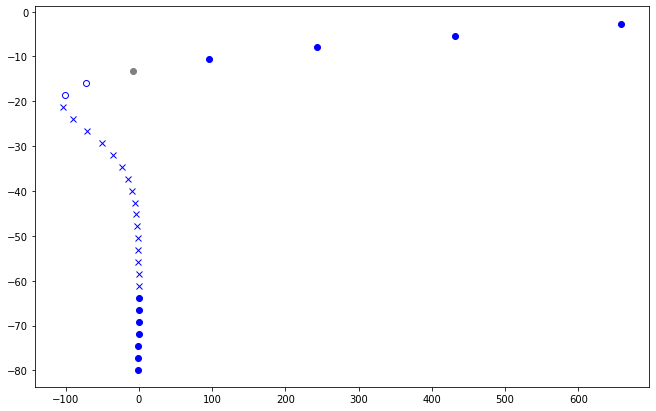

In [98]:
pl.figure(figsize=(11,7)); pl.ioff()
nFP = len(fps)
for n in range(nFP):
  #print(parVals[n],fps[n][1]*p['v_T'],fpTM[n]['marker'])
  pl.plot(parVals[n],fps[n][1]*p['v_T'],fpTM[n]['marker'], markerfacecolor=fpTM[n]['mfc'], markeredgecolor=fpTM[n]['mec'])
pl.ion(); pl.draw()

In [ ]:
class SymbolicModel():
  def __init__():
    pass

class NumericModel()
  def __init__():
    pass

class UDFamily(SymbolicModel,NumericModel):
  def __init__():
    pass

class UD(UDFamily):
  def __init__():
    pass

class ComkComs():
  def __init__():
    pass